# CMIP6 Post-CMOR Plotting Program  
(plotcheck.py)

Goal: After CMORizing E3 output, visualize all variables processed (where possible).
- Ensure that the data are of expected magnitude and distribution and that they are time-varying.
- Compare to available E2.X runs of similar configuration.
- Output key statistics that may give a snapshot overview of run.
- Make simple & efficient. Add complexity later if need be.

In [26]:
import xarray as xr
import pandas as pd
import numpy as np
import glob
import os
import time
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages as pdf

No plev detected
No height detected
No plev detected
No height detected
No E2 match found for tasmax_Amon_GISS-E3-G_historical_r1i1p1f1_gr_200001-201412.nc, skipping...
No plev detected
No height detected
No plev detected
No height detected
No plev detected
No height detected
No plev detected
No height detected
No plev detected
No height detected
No E2 match found for tas_Amon_GISS-E3-G_historical_r1i1p1f1_gr_195001-199912.nc, skipping...
No plev detected
No height detected
No plev detected
No height detected
No plev detected
No height detected
No E2 match found for tasmin_Amon_GISS-E3-G_historical_r1i1p1f1_gr_200001-201412.nc, skipping...
No plev detected
No height detected
Total runtime: 86.47638320922852


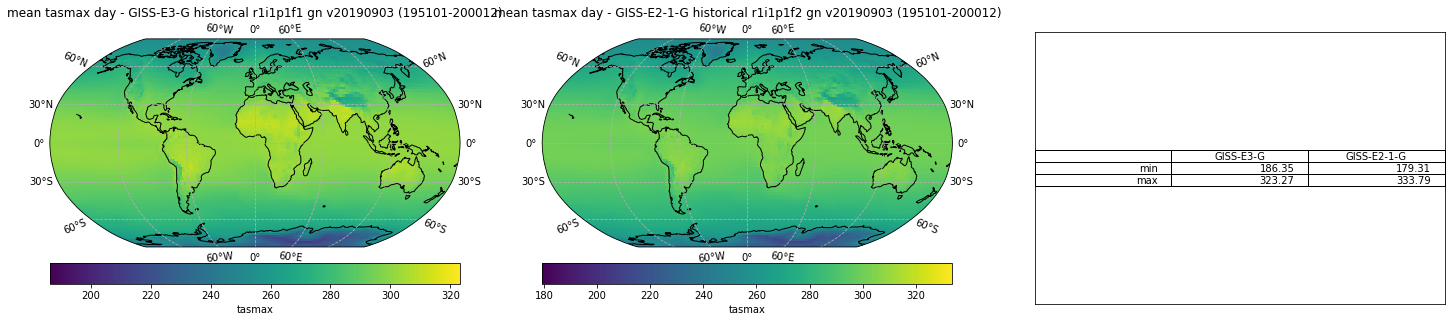

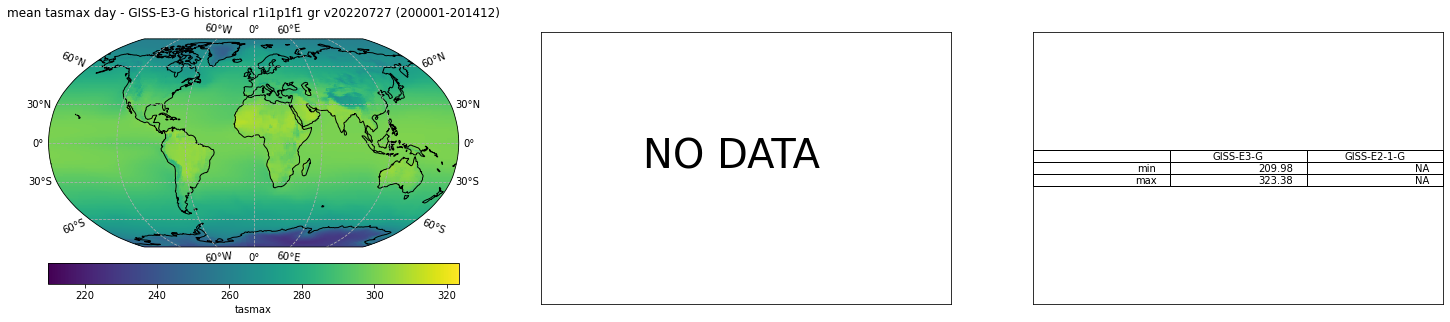

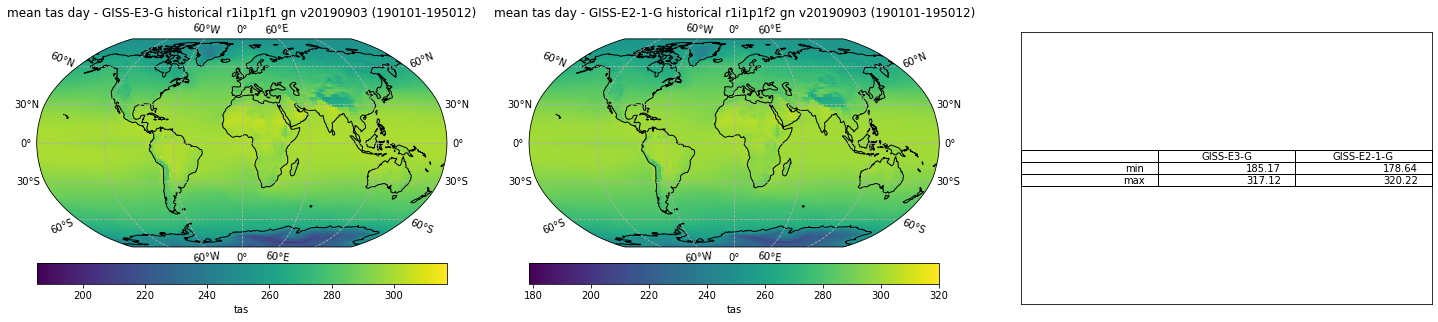

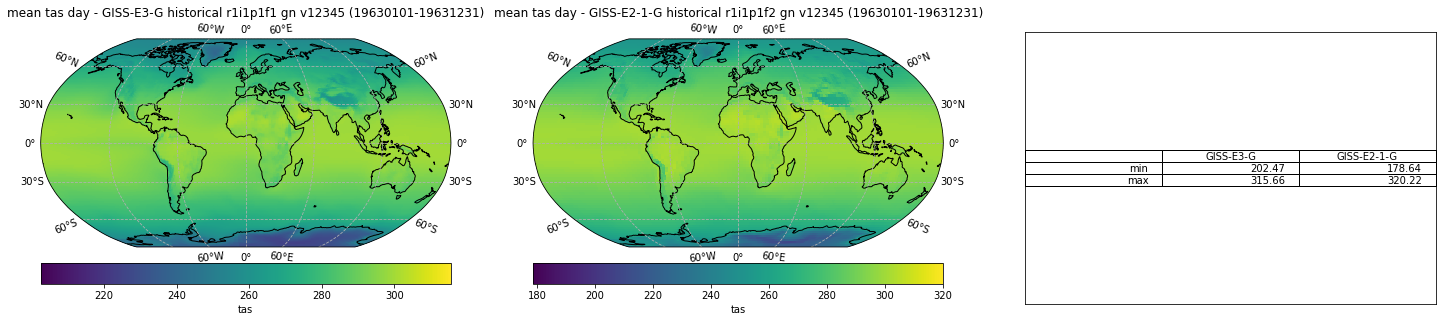

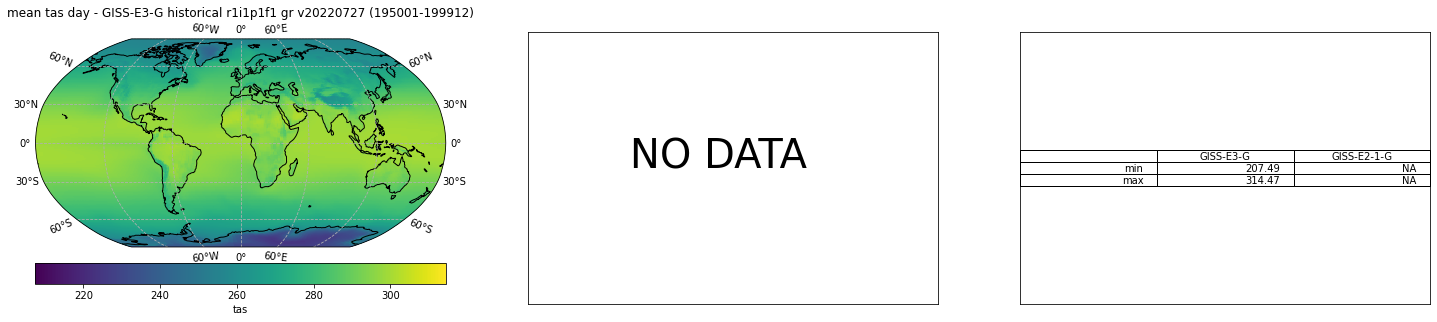

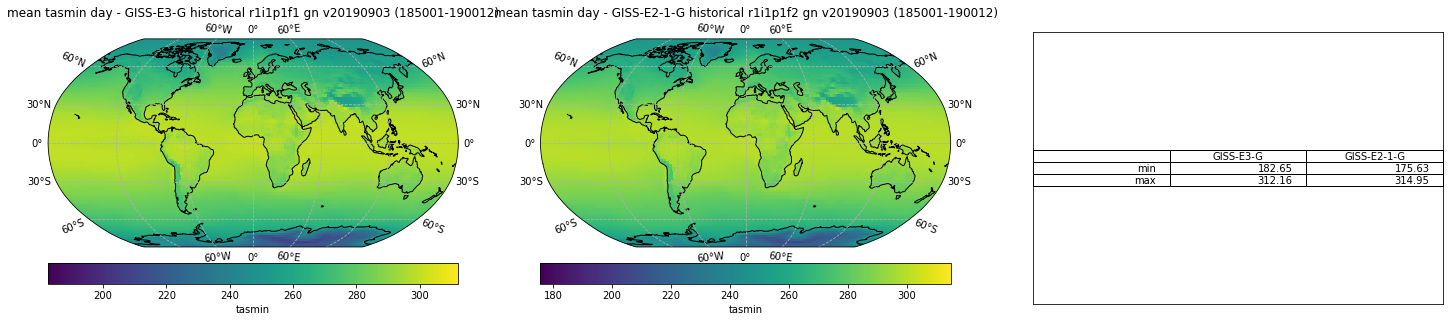

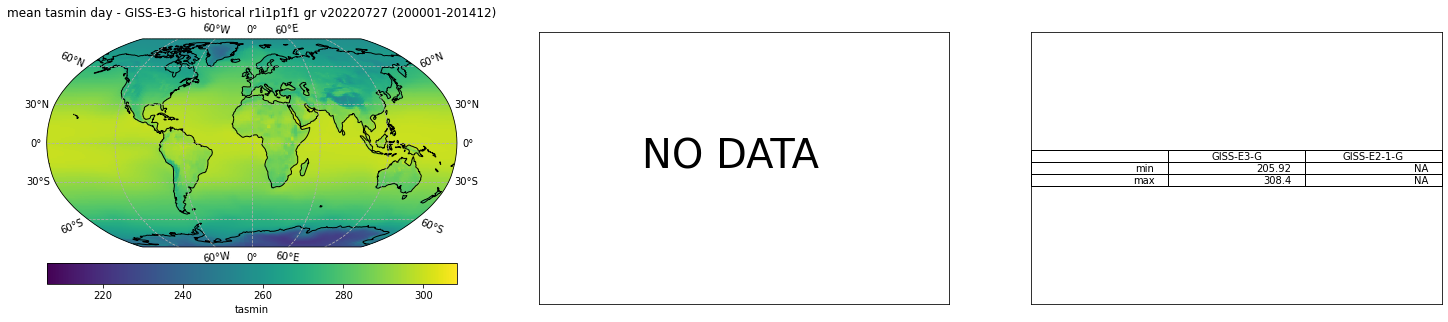

In [27]:
start = time.time()

# Get work directory
#wd = os.getcwd()
wd = "/Users/melling/projects/cmip6/diagnostics/get_plots/cmip6_plotcheck"
# Input the name of the E3 run directory up to the variant label
runE2 = "/Users/melling/projects/cmip6/diagnostics/get_plots/cmip6_plotcheck/testdata/css/cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f2/"
runE3 = "/Users/melling/projects/cmip6/diagnostics/get_plots/cmip6_plotcheck/testdata/css/cmip6/CMIP6/CMIP/NASA-GISS/GISS-E3-G/historical/r1i1p1f1/"
outdir = wd
figname = 'test_CMIP6_plotter'
allvarsE2 = runE2 + "*/*/*/*"
allvarsE3 = runE3 + "*/*/*/*"

pp = pdf('/Users/melling/projects/cmip6/diagnostics/get_plots/cmip6_plotcheck/' + figname + '.pdf')
os.chdir(outdir)

###################################################################################################################################################

# Loop through the E3 directory 
for direc3 in glob.glob(allvarsE3):
    os.chdir(outdir)
    
    # Get a sample file from each variable
    def get_sample(direc, outdir):
        global sample
        
        os.chdir(direc)
        firstfile = os.listdir()[0] # get first file in directory to sample
        os.chdir(outdir)
        sample = direc + '/' + firstfile # Extract the first file in each directory (i.e. the first N years) to sample each var
    
    # Call 'get_sample' for E3, save filename and open dataset
    get_sample(direc3, outdir)
    fileE3 = sample
    # Open the sample E3 file 
    dsE3 = xr.open_dataset(fileE3)
    
    # Get relevant varname & frequency
    freq = direc3.split("/")[-4]
    varname = direc3.split("/")[-3]
    modelv2 = runE2.split('CMIP6')[1].split('/')[3]
    # modelv2 = direc2.split("/")[-7]  # A problem when e2 directory structure not the same
    modelv3 = direc3.split("/")[-7]
    
    # Try to find the same var/freq in E2
    # start here-- basically try to get the same file using the freq and varname defined earlier. if exception, plot no data
    e3version = direc3.split("/")[-1]
    e2path_short = runE2 + direc3.split(e3version)[0].split(runE3)[1]
    e2path_full = e2path_short + "*"
    direc2 = glob.glob(e2path_full)
    if len(direc2) > 0:
        direc2 = direc2[0]
        os.chdir(direc2) # if this fails, there was no path found (aka no matching data)
        get_sample(direc2, outdir)
        fileE2 = sample

        # creat e2 dataset
        dsE2 = xr.open_dataset(fileE2)

        # Verify that E2 variable exists, and carry on
        varexist = 1
    else:
        print("No E2 match found for " + fileE3.split('/')[-1] + ", skipping...")
        dsE2 = None
        varexist = 0
    
    
    # Select first pressure level to sample
    def check_dim(ds):
        try: 
            # set some global variables
            global plev_bin 
            global height_bin 
            
            ds.plev # check if 'plev' is a dimension
            strds = str(ds)
            plev_bin = 1
            locals()[strds] = ds.where(ds['plev'] == ds.plev[0].values) # sample file by slicing first plev
        except:
            print("No plev detected")
            plev_bin = 0

        try:
            ds.height # check if 'height' is a dimension
            height_bin = 1
            locals()[strds] = ds.where(ds['height'] == ds.height[0].values) # sample file by slicing first height
        except:
            print("No height detected")
            height_bin = 0
    
    # Check for num dimensions
    check_dim(dsE3)
    if varexist == 1:
        check_dim(dsE2)
        
    # Get some basic statistics for plotting
    def getstats(ds3, ds2, varexist):
        global maxval
        global minval
        global timemean
        global vmax
        global vmin
        maxval = []
        minval = []
        timemean = []
        vmax = []
        vmin = []
        
        # Get E23 stats
        maxval.append(ds3[varname].max().values)
        minval.append(ds3[varname].min().values)
        timemean.append(ds3[varname].mean('time'))
        vmax.append(ds3[varname].mean('time').max().values)
        vmin.append(ds3[varname].mean('time').min().values)
        # Get E2 stats (if have matching data)
        if varexist == 1:
            maxval.append(ds2[varname].max().values)
            minval.append(ds2[varname].min().values)
            timemean.append(ds2[varname].mean('time'))
            vmax.append(ds2[varname].mean('time').max().values)
            vmin.append(ds2[varname].mean('time').min().values)
        else:
            maxval.append("NA")
            minval.append("NA")
            timemean.append("NA")
            vmax.append("NA")
            vmin.append("NA")
    

    getstats(dsE3, dsE2, varexist)
        
    # Title
    years = fileE3.split('_')[-1].split('.')[0]
    m3title = "mean " + varname + " " + freq + " - " + direc3.split("/")[-7] + " " + direc3.split("/")[-6] + " " + direc3.split("/")[-5] + " " + direc3.split("/")[-2] + " " + direc3.split("/")[-1] + " " + "(" + years + ")"
    if varexist == 1:
        m2title = "mean " + varname + " " + freq + " - " + direc2.split("/")[-7] + " " + direc2.split("/")[-6] + " " + direc2.split("/")[-5] + " " + direc3.split("/")[-2] + " " + direc3.split("/")[-1] + " " + "(" + years + ")"
    
    # Plot vals
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (25, 13))
    plt.subplots_adjust(hspace = 0.6)
    central_lon = 0
    ax = plt.axes(projection=ccrs.Robinson())
    
    # E3
    ax1 = plt.subplot(2, 3, 1, projection=ccrs.Robinson(central_lon))
    ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
    timemean[0].plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','pad': 0.06}, 
                    vmax = maxval[0], vmin = minval[0])
    plt.title(m3title)
    ax1.coastlines();

    # E2
    if varexist == 1:
        ax2 = plt.subplot(2, 3, 2, projection=ccrs.Robinson(central_lon))
        ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
        timemean[1].plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','pad': 0.06}, 
                        vmax = maxval[1], vmin = minval[1])
        plt.title(m2title)
        ax2.coastlines();
    else:
        ax2 = plt.subplot(2, 3, 2)#projection=ccrs.Robinson(central_lon))
        ax2.text(0.25, 0.5, 'NO DATA', fontsize = 40)
        plt.xticks([])
        plt.yticks([])
    
    # Key statistics
    df = pd.DataFrame()
    df[" "] = ["min", "max"]

    df[modelv3] = [np.round(minval[0], 2), np.round(maxval[0], 2)]
    try:
        df[modelv2] = [np.round(minval[1], 2), np.round(maxval[1], 2)]
    except: # If no  E2 data, rounding will not work. Just append "NA" string
        df[modelv2] = [minval[1], maxval[1]]
    
    ax3 = plt.subplot(2, 3, 3)
    ax3.table(cellText=df.values, colLabels=df.keys(), loc='center')
    plt.xticks([])
    plt.yticks([])
    
    # Save figure
    pp.savefig()
pp.close()


end = time.time()
totalt = end - start
print("Total runtime: " + str(totalt) + " seconds")

#### To do next: Investigate whether the 'gr' and 'gn' grid matter  
not super important but could count variables iterated for time reference